Practical Work: Out-of-Distribution Detection, OOD Scoring Methods, and Neural Collapse.

# 1. Training a ResNet18 classifier on CIFAR-100 with PyTorch

In [33]:
import torch
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [34]:
# Hyperparameters
batch_size = 8
num_workers = 8
lr = 1e-3
momentum = 0.95
weight_decay = 1e-3
epochs = 200

# Random seed
torch.manual_seed(42)

In [35]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Add RandomCrop
    transforms.RandomHorizontalFlip(),    # Add RandomHorizontalFlip
    transforms.RandomRotation(15),        # Add RandomRotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Add ColorJitter
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    transforms.RandomErasing(p=0.2),      # Add RandomErasing
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


# Load CIFAR-100
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Model configuration
model = resnet18(False) # Load ResNet-18 model without pre-trained weights
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3), # Add Dropout
    torch.nn.Linear(model.fc.in_features, 100)  # Adjust final layer for 100 classes
)
model = model.cuda() # Move model to GPU

# Optim, Loss, Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"Epoch {epoch}: Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

# Simple Test Loop
def test(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate test loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    print(f"Test Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc




Using device: cuda


Epoch 0: Loss: 4.3794 | Acc: 4.73%
Test Accuracy: 10.97%
Epoch 1: Loss: 4.0101 | Acc: 8.36%
Test Accuracy: 15.54%
Epoch 2: Loss: 3.8178 | Acc: 11.36%
Test Accuracy: 18.83%
Epoch 3: Loss: 3.6736 | Acc: 13.27%
Test Accuracy: 20.74%
Epoch 4: Loss: 3.5527 | Acc: 15.51%
Test Accuracy: 23.84%
Epoch 5: Loss: 3.4500 | Acc: 17.20%
Test Accuracy: 25.77%
Epoch 6: Loss: 3.3548 | Acc: 19.13%
Test Accuracy: 27.55%
Epoch 7: Loss: 3.2736 | Acc: 20.62%
Test Accuracy: 30.06%
Epoch 8: Loss: 3.1962 | Acc: 22.04%
Test Accuracy: 30.19%
Epoch 9: Loss: 3.1481 | Acc: 23.10%
Test Accuracy: 31.07%
Epoch 10: Loss: 3.0886 | Acc: 24.12%
Test Accuracy: 34.19%
Epoch 11: Loss: 3.0471 | Acc: 25.04%
Test Accuracy: 35.64%
Epoch 12: Loss: 3.0032 | Acc: 25.88%
Test Accuracy: 35.90%
Epoch 13: Loss: 2.9854 | Acc: 26.02%
Test Accuracy: 36.07%
Epoch 14: Loss: 2.9542 | Acc: 27.26%
Test Accuracy: 38.47%
Epoch 15: Loss: 2.9312 | Acc: 27.54%
Test Accuracy: 37.80%
Epoch 16: Loss: 2.9006 | Acc: 28.13%
Test Accuracy: 39.05%
Epoch 17:

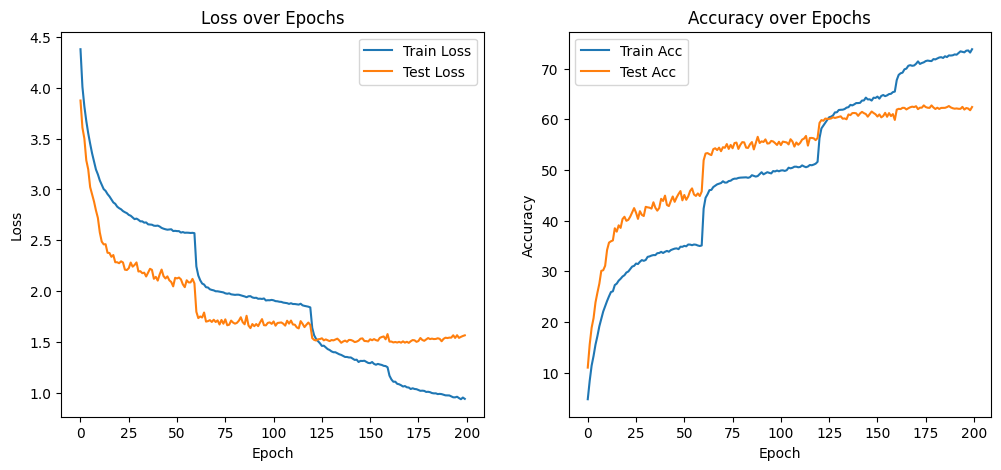

In [36]:
# Main training and testing loop
for epoch in range(epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    scheduler.step()

# Save model
torch.save(model.state_dict(), 'resnet18_cifar100.pth')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 2. Max Softmax Probability (MSP). 
If the classifier assigns low maximum probability, it is unsure or the input may be OOD.

Score: the maximum softmax probability
$$s_{max-prob}(x)=max \quad p(y=c|x)=max \quad softmax(z_c(x))$$

In [ ]:
def msp_score(model, loader):
    model.eval()
    all_scores = []

    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = F.softmax(logits, dim=1)

            max_probs, _ = torch.max(probs, dim=1)
            
            all_scores.append(max_probs.cpu())
            
    return torch.cat(all_scores)

msp_scores = msp_score(model, test_loader)

print(f"MSP scores: {msp_scores}")

MSP scores: tensor([0.2823, 0.5961, 0.5993,  ..., 0.9984, 0.4761, 0.8954])


# 3. Max Logit technique. 
Logits reflect raw model evidence before the softmax normalization; using logits avoids saturating effects of softmax.
$$s_{max-logit}(x)=max \quad z_c(x)$$

In [ ]:
def max_logit_score(model, loader):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            max_logits, _ = torch.max(logits, dim=1)
            all_scores.append(max_logits.cpu())
    return torch.cat(all_scores)

max_logit_scores = max_logit_score(model, test_loader)
print(f"Max logit scores: {max_logit_scores}")

Max logit scores: tensor([ 5.9505,  6.6232,  8.0241,  ..., 12.3481,  6.2112,  9.2270])


# 4. Energy-based OOD score.

Energy provides a scalar that correlates with the model’s
total evidence across classes. Lower energy (more negative) implies
stronger evidence; higher energy (less negative or positive) can
indicate OOD. Energy score derived from the logits: a common definition:

$$  E(x) = -log(\sum_{c}{ }e^{z_c(x)}) = -LSE(z(x))$$

With temperature $T>0$ one can use:
$$ E_T(x) = -T*log(\sum_{c}{ }e^{z_c(x)/T})$$

In [ ]:
def energy_score(model, loader):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            energy = torch.logsumexp(logits, dim=1)
            all_scores.append(energy.cpu())
    return torch.cat(all_scores)

energy_scores = energy_score(model, test_loader)
print(f"Energy scores: {energy_scores}")

Energy scores: tensor([ 7.2153,  7.1406,  8.5361,  ..., 12.3497,  6.9534,  9.3375])


# 5. Mahalanobis Distance-based Detection

$$ d_{ \sf M a h a } ( x ) = \operatorname* { m i n } _ { c } \, ( f ( x ) - \mu _ { c } ) ^ { \top } \Sigma ^ { - 1 } ( f ( x ) - \mu _ { c } )

In [ ]:
def mahalanobis_score(model, loader):
    model.eval()
    all_scores = []
    feature_list = []

    # First pass: collect features
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            features = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(inputs))))))))
            features = features.view(features.size(0), -1)
            feature_list.append(features.cpu())

    features = torch.cat(feature_list)
    mean = torch.mean(features, dim=0)
    cov = torch.cov(features.T) + 0.01 * torch.eye(features.size(1))
    inv_cov = torch.inverse(cov)

    # Second pass: compute Mahalanobis distance
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            features = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(inputs))))))))
            features = features.view(features.size(0), -1)
            diff = features.cpu() - mean
            m_dist = torch.sqrt(torch.diag(diff @ inv_cov @ diff.T))
            all_scores.append(-m_dist)  # Negative distance as score

    return torch.cat(all_scores)

mahalanobis_scores = mahalanobis_score(model, test_loader)
print(f"Mahalanobis scores: {mahalanobis_scores}")

Mahalanobis scores: tensor([-12.7569, -12.7100, -12.1660,  ..., -16.6987, -14.6202, -16.0362])
